In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Comparing volunteer interview show rates b/w Actuity & Outlook

Assume that there is some true 0<p_show_rate<1 probability that volunteers who book an interview, eventually show up to it. The observed p_show_rate is not the true p_show_rate, but we can infer the true p_show_rate from the prior and observed p_show_rate. 
* We are interested in using what we know, N (the total number of vols that booked interviews) and n (the number of vols that showed up), to estimate what p_show_rate, the true frequency of interview-shows, might be. 

January Percentage of CANCELLATIONS + NO-SHOWS: 
* Vols shown Outlook: 10 didn't show, from 71 that signed up
* Vols shown Acuity: 7 didn't show, from 72 that signed up

**P(true_p_showrate | observed_p_showrate) = P(obsrvd_p_showrate | true_p_showrate)*P(true_p_showrate)**

In [19]:
# Outlook: 10 didn't show or cancelled, from 71 that signed up
# Acuity: 7 didn't show or cancelled, from 72 that signed up

# create 2 arrays (Outlook,Acuity) with 0's for no-shows or cancellations, 1 for show
outlook = np.zeros(10)
#insert the integer 1 sixty-one times in random places
outlook_no_shows = np.insert(outlook, np.random.randint(low=0,high=11,size=61), 1) 
outlook_no_shows = outlook_no_shows.astype(int)

acuity = np.zeros(7)
acuity_no_shows = np.insert(acuity, np.random.randint(low=0,high=8,size=65), 1) 
acuity_no_shows = acuity_no_shows.astype(int)

#Sidenote: if the array starts with many 1's, then the kernel shuts down
print('Acuity_show_rate(len={}):\n{}'.format((len(acuity_no_shows)), 
                                           acuity_no_shows))# P(observed_p_showrate) for acuity
print('Outlook_show_rate(len={}):\n{}'.format((len(outlook_no_shows)), 
                                           outlook_no_shows))# P(observed_p_showrate) for outlook
print('Acuity_show_rate mean:',np.mean(acuity_no_shows))
print('Outlook_show_rate mean:',np.mean(outlook_no_shows))

Acuity_show_rate(len=72):
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1]
Outlook_show_rate(len=71):
[1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]
Acuity_show_rate mean: 0.9027777777777778
Outlook_show_rate mean: 0.8591549295774648


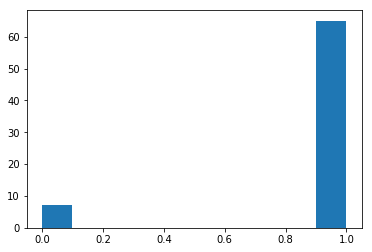

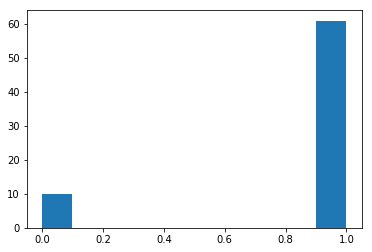

In [25]:
plt.hist(acuity_no_shows)
plt.show()
plt.hist(outlook_no_shows)
plt.show()

Both datasets are discrete and seem to follow a bernoulli distribution. For more information on what a bernoulli distribution looks like, we used pymc3 to artifically generate one below.

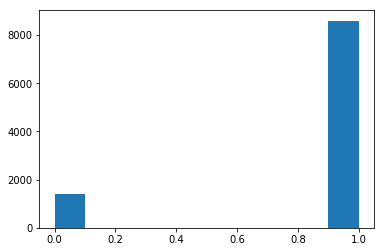

In [40]:
plt.hist(pm.Bernoulli.dist(0.87).random(size=10000))
plt.show()

Looks very similar to our own data distribution. As a result, we shall use Bernouli to calculate our likelihood.

pm.Bernoulli() takes one paramater,p, which is probability of success. Knowing that, we have to find a prior for p. 

We shall use a uniform distribution from 0-1 for this prior, meaning that we are claiming complete ignorance about the prior for p because anything between 0 to 1 is as likely. ((pm.Beta.dist(1,1) is another option instead of a uniform distribution, if we prefer.)

In [20]:
with pm.Model() as model:
    # we'll choose a uniform prior for probability of of show_rate 
    p_acuity = pm.Uniform("p_acuity", 0, 1)                       # Prior: P(true_p_showrate) for acuity
    p_outlook = pm.Uniform("p_outlook", 0, 1)                     # Prior: P(true_p_showrate) for outlook
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_acuity - p_outlook)

    # Set of observations                                         #likelihood: P(obsrvd_p_showrate | true_p_showrate)
    obs_acuity = pm.Bernoulli("obs_acuity", p_acuity, observed=acuity_no_shows)
    obs_outlook = pm.Bernoulli("obs_outlook", p_outlook, observed=outlook_no_shows)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_outlook_interval__]
>Metropolis: [p_acuity_interval__]
The number of effective samples is smaller than 25% for some parameters.


Draw samples

In [21]:
p_acuity_samples = burned_trace["p_acuity"]
p_outlook_samples = burned_trace["p_outlook"]
delta_samples = burned_trace["delta"]

In [44]:
pm.summary(burned_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_acuity,0.891767,0.036167,0.000489,0.818065,0.954445,4245.399412,1.000052
p_outlook,0.849251,0.040670,0.000679,0.767572,0.925448,3677.878085,1.002493
delta,0.042516,0.054330,0.000846,-0.066333,0.147575,4202.500094,1.001943


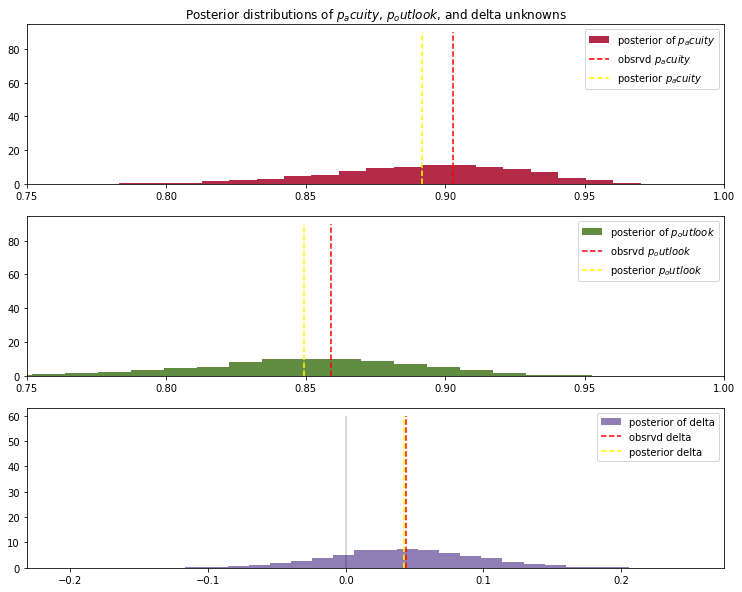

In [45]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)

plt.xlim(0.75, 1)
plt.hist(p_acuity_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_acuity$", color="#A60628", normed=True)
plt.vlines(np.mean(acuity_no_shows), 0, 90, linestyle="--", label="obsrvd $p_acuity$", color='red')
plt.vlines(np.mean(p_acuity_samples), 0, 90, linestyle="--", label="posterior $p_acuity$", color='yellow')
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_acuity$, $p_outlook$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0.75, 1)
plt.hist(p_outlook_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_outlook$", color="#467821", normed=True)
plt.vlines(np.mean(outlook_no_shows), 0, 90, linestyle="--", label="obsrvd $p_outlook$", color='red')
plt.vlines(np.mean(p_outlook_samples), 0, 90, linestyle="--", label="posterior $p_outlook$", color='yellow')

plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)

plt.vlines(np.mean(acuity_no_shows)-np.mean(outlook_no_shows), 0, 60, linestyle="--", label="obsrvd delta", color='red')
plt.vlines(np.mean(delta_samples), 0, 60, linestyle="--",
           label="posterior delta", color='yellow')
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");
plt.show()

With respect to the posterior distribution of delta, we can see that the majority of the distribution is ABOVE delta=0, implying that acuity's show rate is likely BETTER than outlook's show rate. The probability this inference is incorrect is easily computable:

In [50]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that A (acuity) is worse than B (outlook).
print("Probability that acuity has WORSE (lower) show rate than outlook's show rate isk: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability that acuity has BETTER (higher) show rate than outlook's show rate is: %.3f" % \
    np.mean(delta_samples > 0))

Probability that acuity has WORSE (lower) show rate than outlook's show rate isk: 0.207
Probability that acuity has BETTER (higher) show rate than outlook's show rate is: 0.793


pymc3 offers a nice and quick way to show this below.

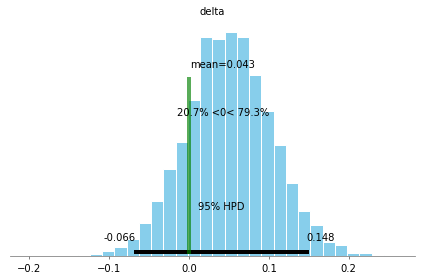

In [53]:
pm.plot_posterior(burned_trace,
                  varnames=['delta'], 
                  ref_val=0, 
                  color='#87ceeb')
plt.show()

Summary: 
* there is a 79.3% probability that Acuity's show rate is better than Outlook's. 
* on average, Acuity's show rate is 0.04% higher than Outlook's

# Comparing Men interview show rate b/w actuity & outlook in Jan-Feb

* Outlook: 22/25 + 7/7   =  29 showed out of 32 booked
* Acuity:  29/30 + 41/48 =  70 showed out of 78 booked

In [60]:
# create 2 arrays (Outlook,Acuity) with 0's for no-show or cancellation, 1 for show
outlook = np.zeros(3) #29 out of 32
#insert the integer 1 twenty nine times in random places
outlook_no_shows = np.insert(outlook, np.random.randint(low=0,high=4,size=29), 1) 
outlook_no_shows = outlook_no_shows.astype(int)

acuity = np.zeros(8) #70 out of 78 
acuity_no_shows = np.insert(acuity, np.random.randint(low=0,high=9,size=70), 1) 
acuity_no_shows = acuity_no_shows.astype(int)

#Sidenote: if the array starts with many 1's, then the kernel shuts down
print ('Acuity_show_rate:')
print(acuity_no_shows)                                         # observed_p_showrate for acuity
print ('Outlook_show_rate:')
print(outlook_no_shows)                                        # observed_p_showrate for outlook
print('Accuity_show_rate mean: ',np.mean(acuity_no_shows))
print('Outlook_show_rate mean: ',np.mean(outlook_no_shows))

Acuity_show_rate:
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1]
Outlook_show_rate:
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
Accuity_show_rate mean:  0.8974358974358975
Outlook_show_rate mean:  0.90625


Here we create the same model as above because the data, similarily, follows a Bernoulli distribution

In [61]:
with pm.Model() as model:
    p_acuity = pm.Uniform("p_acuity", 0, 1)                                 # Prior: P(true_p_showrate) for acuity
    p_outlook = pm.Uniform("p_outlook", 0, 1)                               # Prior: P(true_p_showrate) for outlook
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_acuity - p_outlook)

    # Set of observations                                         #likelihood P(obsrvd_p_showrate | true_p_showrate)
    obs_acuity = pm.Bernoulli("obs_acuity", p_acuity, observed=acuity_no_shows)
    obs_outlook = pm.Bernoulli("obs_outlook", p_outlook, observed=outlook_no_shows)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_outlook_interval__]
>Metropolis: [p_acuity_interval__]
The number of effective samples is smaller than 25% for some parameters.


In [62]:
p_acuity_samples = burned_trace["p_acuity"]
p_outlook_samples = burned_trace["p_outlook"]
delta_samples = burned_trace["delta"]

In [63]:
pm.summary(burned_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_acuity,0.888428,0.035168,0.000598,0.817607,0.950397,4072.683530,1.000802
p_outlook,0.883374,0.054305,0.000871,0.777872,0.978979,4503.721406,0.999958
delta,0.005054,0.064816,0.001032,-0.112181,0.139996,4389.722597,1.000108


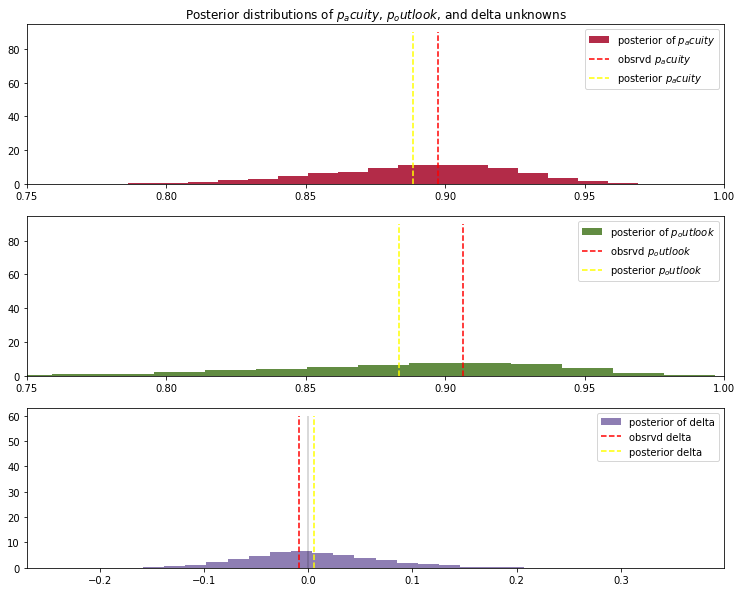

In [64]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)

plt.xlim(0.75, 1)
plt.hist(p_acuity_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_acuity$", color="#A60628", normed=True)
plt.vlines(np.mean(acuity_no_shows), 0, 90, linestyle="--", label="obsrvd $p_acuity$", color='red')
plt.vlines(np.mean(p_acuity_samples), 0, 90, linestyle="--", label="posterior $p_acuity$", color='yellow')
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_acuity$, $p_outlook$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0.75, 1)
plt.hist(p_outlook_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_outlook$", color="#467821", normed=True)
plt.vlines(np.mean(outlook_no_shows), 0, 90, linestyle="--", label="obsrvd $p_outlook$", color='red')
plt.vlines(np.mean(p_outlook_samples), 0, 90, linestyle="--", label="posterior $p_outlook$", color='yellow')

plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)

plt.vlines(np.mean(acuity_no_shows)-np.mean(outlook_no_shows), 0, 60, linestyle="--", label="obsrvd delta", color='red')
plt.vlines(np.mean(delta_samples), 0, 60, linestyle="--",
           label="posterior delta", color='yellow')
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");
plt.show()

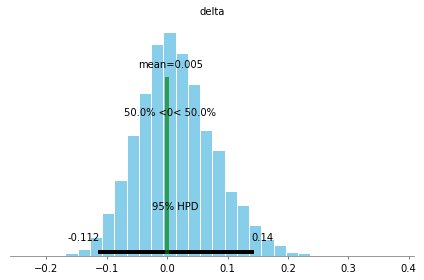

In [65]:
pm.plot_posterior(burned_trace,
                  varnames=['delta'], 
                  ref_val=0, 
                  color='#87ceeb')
plt.show()

We see much more uncertainty in p_outlook value (distribution is flatter, the N is a lot smaller), which is why the posterior adjusts a lot more (towards 0.5 due to uniform probability of prior p) than it does for the p_acuity. **As a result, although outlook's avg. show rate when data was observed was initialy higher than acuity's, its posterior show rate is now lower than acuity's due to its low N and high degree of uncertainty.**

Summay:
* when measuring show rates to interviews just for men, outlook system is just as good as acuity